# Making Unrolled Neural Network (Variational Network)
Finally, we will be making an unrolled neural network called "Variational Network" <br>
This network is inspired by gradient descent optimization for compressed sensing problem <br>
We will use module by fastmri <br>

$$\min_x \frac{1}{2} \| \underbrace{P F S }_{A} x - y \|_2^2 + \lambda \Phi (x)$$

## Gradient descent solution to the above problem:

$$x^{t+1} = x^t - \eta^{t}(A^* (A(x) -y) + \lambda \Psi(x)) $$

## Relating this to DL

$$x^{t+1} = x^t - \eta^{t}(A^* (A(x) - y) + \lambda CNN(x)) $$

Where y is undersampled kspace, A is combination of P,F,S, $x^t$ is the intermediate image in t iteration, $\eta^t$ is the gradient descent step in t iteration

In [14]:
import numpy as np

import fastmri
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastmri.data import transforms
import sigpy.plot as pl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

from fastmri.models.unet import Unet
from fastmri.models.varnet import *
from dloader import genDataLoader

In [2]:
# We can make one iteration block like this
class VarNetBlock(nn.Module):
    """
    This model applies a combination of soft data consistency with the input
    model as a regularizer. A series of these blocks can be stacked to form
    the full variational network.
    """

    def __init__(self, model: nn.Module):
        """
        Args:
            model: Module for "regularization" component of variational
                network.
        """
        super().__init__()

        self.model = model
        self.eta = nn.Parameter(torch.ones(1)) # eta variable (traineable)

    def sens_expand(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        return fastmri.fft2c(fastmri.complex_mul(x, sens_maps)) # F*S operator

    def sens_reduce(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        x = fastmri.ifft2c(x)
        return fastmri.complex_mul(x, fastmri.complex_conj(sens_maps)).sum(
            dim=1, keepdim=True
        ) # S^H * F^H operator

    def forward(
        self,
        current_kspace: torch.Tensor,
        ref_kspace: torch.Tensor,
        mask: torch.Tensor,
        sens_maps: torch.Tensor,
    ) -> torch.Tensor:
        zero = torch.zeros(1, 1, 1, 1, 1).to(current_kspace)
        soft_dc = torch.where(mask, current_kspace - ref_kspace, zero) * self.eta
        model_term = self.sens_expand(
            self.model(self.sens_reduce(current_kspace, sens_maps)), sens_maps
        )

        return current_kspace - soft_dc - model_term

In [3]:
# now we can stack VarNetBlocks to make a unrolled VarNet (with 10 blocks)


class VarNet(nn.Module):
    """
    A full variational network model.

    This model applies a combination of soft data consistency with a U-Net
    regularizer. To use non-U-Net regularizers, use VarNetBock.
    """

    def __init__(
        self,
        num_cascades: int = 10,
        chans: int = 18,
        pools: int = 4,
    ):
        super().__init__()

        self.cascades = nn.ModuleList(
            [VarNetBlock(NormUnet(chans, pools)) for _ in range(num_cascades)]
        )

    def forward(self, masked_kspace: torch.Tensor, mask: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        kspace_pred = masked_kspace.clone()

        for cascade in self.cascades:
            kspace_pred = cascade(kspace_pred, masked_kspace, mask, sens_maps)
        
        im_coil = fastmri.ifft2c(kspace_pred)
        im_comb = fastmri.complex_mul(im_coil, fastmri.complex_conj(sens_maps)).sum(
            dim=1, keepdim=True
        )
        
        return im_comb

In [4]:
varnet = VarNet() # first construct VarNet
basefolder = '/mnt/dense/kanghyun/summer_dset/div_coronal_pd/Test'
dloader = genDataLoader(basefolder)

In [5]:
# test if backpropagation works
# if no error then backpropagation is working
test_dloader = iter(dloader)
kspace, mask, sens, im_true = next(test_dloader)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(varnet.parameters(),lr=0.0002)
optimizer.zero_grad() 
im_est = varnet(kspace,mask,sens)
loss = criterion(im_est, im_true)
print('Initial Loss:', loss.item())
loss.backward() # this performs the backprop
optimizer.step() # this performs the gradient update


Initial Loss: 0.2435145527124405


In [6]:
# now perform this on cuda
varnet_gpu = varnet.to('cuda:0')
kspace_gpu, mask_gpu, sens_gpu, im_true_gpu = kspace.to('cuda:0'), mask.to('cuda:0'), sens.to('cuda:0'), im_true.to('cuda:0')

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(varnet_gpu.parameters(),lr=0.0002)
optimizer.zero_grad() 
im_est_gpu = varnet(kspace_gpu,mask_gpu,sens_gpu)
loss = criterion(im_est_gpu, im_true_gpu)
print('Initial Loss:', loss.item())
loss.backward() # this performs the backprop
optimizer.step() # this performs the gradient update



Initial Loss: 0.17735962569713593


In [8]:
# let's train for a short epoch on the test set
# See if loss is decreasing (network is learning something)
Nepoch = 5
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(varnet_gpu.parameters(),lr=0.0002)

for epoch in range(Nepoch):
    loss_epoch = 0
    for kspace, mask, sens, im_true in dloader:
        kspace_gpu, mask_gpu, sens_gpu, im_true_gpu = kspace.to('cuda:0'), mask.to('cuda:0'), sens.to('cuda:0'), im_true.to('cuda:0')
        optimizer.zero_grad() 
        im_est_gpu = varnet(kspace_gpu,mask_gpu,sens_gpu)
        loss = criterion(im_est_gpu, im_true_gpu)
        loss.backward() # this performs the backprop
        optimizer.step() # this performs the gradient update
        loss_epoch += loss.item()
    print('epoch:{}/{} Mean Loss: {}'.format(epoch, Nepoch, loss_epoch / len(dloader))) # report loss for end of the epoch


epoch:0/5 Mean Loss: 0.03748947155705634
epoch:1/5 Mean Loss: 0.02621522467058377
epoch:2/5 Mean Loss: 0.024013969415936295
epoch:3/5 Mean Loss: 0.02316436589689263
epoch:4/5 Mean Loss: 0.022735102483440166


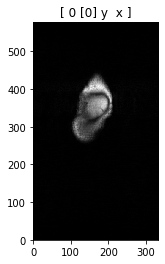

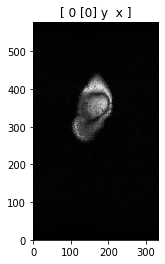

In [15]:
%matplotlib inline
# Let's look at the final produced image
im_est = transforms.tensor_to_complex_np(im_est_gpu.cpu().detach())
im_true = transforms.tensor_to_complex_np(im_true_gpu.cpu().detach())

pl.ImagePlot(im_est) # this is est image
pl.ImagePlot(im_true) # this is true image

# it produces some kind of similar images
